# Modeling

## Loading Imports and Data

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna

In [25]:
project_root = Path().resolve().parent  # Assuming you're running the script from the notebooks directory

train_FD001_processed = pd.read_csv(project_root/'data/processed/train_FD001.csv')
test_FD001_processed = pd.read_csv(project_root/'data/processed/test_FD001.csv')

train_FD002_processed = pd.read_csv(project_root/'data/processed/train_FD002.csv')
test_FD002_processed = pd.read_csv(project_root/'data/processed/test_FD002.csv')

train_FD003_processed = pd.read_csv(project_root/'data/processed/train_FD003.csv')
test_FD003_processed = pd.read_csv(project_root/'data/processed/test_FD003.csv')

train_FD004_processed = pd.read_csv(project_root/'data/processed/train_FD004.csv')
test_FD004_processed = pd.read_csv(project_root/'data/processed/test_FD004.csv')

print(train_FD001_processed.head())

   0  1         6         7         8        10        11        12        13  \
0  1  1 -1.721725 -0.134255 -0.925936  0.141683  1.121141 -0.516338 -0.862813   
1  1  2 -1.061780  0.211528 -0.643726  0.141683  0.431930 -0.798093 -0.958818   
2  1  3 -0.661813 -0.413166 -0.525953  0.141683  1.008155 -0.234584 -0.557139   
3  1  4 -0.661813 -1.261314 -0.784831  0.141683  1.222827  0.188048 -0.713826   
4  1  5 -0.621816 -1.251528 -0.301518  0.141683  0.714393 -0.516338 -0.457059   

         15        16        17        18        19        21        24  \
0 -0.266467  0.334262 -1.058890 -0.269071 -0.603816 -0.781710  1.348493   
1 -0.191583  1.174899 -0.363646 -0.642845 -0.275852 -0.781710  1.016528   
2 -1.015303  1.364721 -0.919841 -0.551629 -0.649144 -2.073094  0.739891   
3 -1.539489  1.961302 -0.224597 -0.520176 -1.971665 -0.781710  0.352598   
4 -0.977861  1.052871 -0.780793 -0.521748 -0.339845 -0.136018  0.463253   

         25  RUL  
0  1.194427  191  
1  1.236922  190  
2  0.

## Scaling the RUL Target Data using Min Max Scaler

In [26]:
FD001_scaler = MinMaxScaler(feature_range=(0,1))
FD002_scaler = MinMaxScaler(feature_range=(0,1))
FD003_scaler = MinMaxScaler(feature_range=(0,1))
FD004_scaler = MinMaxScaler(feature_range=(0,1))

train_FD001_processed.iloc[:, -1] = FD001_scaler.fit_transform(train_FD001_processed.iloc[:, -1].values.reshape(-1, 1))
train_FD002_processed.iloc[:, -1] = FD002_scaler.fit_transform(train_FD002_processed.iloc[:, -1].values.reshape(-1, 1))
train_FD003_processed.iloc[:, -1] = FD003_scaler.fit_transform(train_FD003_processed.iloc[:, -1].values.reshape(-1, 1))
train_FD004_processed.iloc[:, -1] = FD004_scaler.fit_transform(train_FD004_processed.iloc[:, -1].values.reshape(-1, 1))

print(train_FD001_processed.head())

   0  1         6         7         8        10        11        12        13  \
0  1  1 -1.721725 -0.134255 -0.925936  0.141683  1.121141 -0.516338 -0.862813   
1  1  2 -1.061780  0.211528 -0.643726  0.141683  0.431930 -0.798093 -0.958818   
2  1  3 -0.661813 -0.413166 -0.525953  0.141683  1.008155 -0.234584 -0.557139   
3  1  4 -0.661813 -1.261314 -0.784831  0.141683  1.222827  0.188048 -0.713826   
4  1  5 -0.621816 -1.251528 -0.301518  0.141683  0.714393 -0.516338 -0.457059   

         15        16        17        18        19        21        24  \
0 -0.266467  0.334262 -1.058890 -0.269071 -0.603816 -0.781710  1.348493   
1 -0.191583  1.174899 -0.363646 -0.642845 -0.275852 -0.781710  1.016528   
2 -1.015303  1.364721 -0.919841 -0.551629 -0.649144 -2.073094  0.739891   
3 -1.539489  1.961302 -0.224597 -0.520176 -1.971665 -0.781710  0.352598   
4 -0.977861  1.052871 -0.780793 -0.521748 -0.339845 -0.136018  0.463253   

         25       RUL  
0  1.194427  0.529086  
1  1.236922  0

## Splitting Training Data and Validation Data

Here we split the training and validation data to 80% training and 20% validation. We split the data by 80% and 20% engine ID's. This is done to keep the temporal dependencies of the data.

In [27]:
def split_by_engine(data, engine_column):
    # Get unique engine IDs
    unique_engines = data.iloc[:, engine_column].unique()
    
    # Split engine IDs into training (80%) and validation (20%) sets
    train_engines, val_engines = train_test_split(unique_engines, test_size=0.2, random_state=42)
    
    # Filter data based on engine IDs
    train_data = data[data.iloc[:, engine_column].isin(train_engines)]
    val_data = data[data.iloc[:, engine_column].isin(val_engines)]
    
    return train_data, val_data

FD001_train_data, FD001_val_data = split_by_engine(train_FD001_processed, engine_column=0)
FD002_train_data, FD002_val_data = split_by_engine(train_FD002_processed, engine_column=0)
FD003_train_data, FD003_val_data = split_by_engine(train_FD003_processed, engine_column=0)
FD004_train_data, FD004_val_data = split_by_engine(train_FD004_processed, engine_column=0)

print(f"FD001 Training data shape: {FD001_train_data.shape}")
print(f"FD001 Validation data shape: {FD001_val_data.shape}")

print(f"FD002 Training data shape: {FD002_train_data.shape}")
print(f"FD002 Validation data shape: {FD002_val_data.shape}")

print(f"FD003 Training data shape: {FD003_train_data.shape}")
print(f"FD003 Validation data shape: {FD003_val_data.shape}")

print(f"FD004 Training data shape: {FD004_train_data.shape}")
print(f"FD004 Validation data shape: {FD004_val_data.shape}")

FD001 Training data shape: (16561, 18)
FD001 Validation data shape: (4070, 18)
FD002 Training data shape: (43464, 27)
FD002 Validation data shape: (10295, 27)
FD003 Training data shape: (20012, 16)
FD003 Validation data shape: (4708, 16)
FD004 Training data shape: (49294, 27)
FD004 Validation data shape: (11955, 27)


## Sliding Window Approach

We use a sliding window approach to create overlapping segments of data. This is important because because the sequences of past data is important when determining the RUL.

We make sure to use the implement the sliding window engine by engine as we dont want the window to pick up any sequences of data from other engines.

We will also pad the data with zeros if the data doesnt have enough data for our window size.

In [28]:
def process_data_with_sliding_windows(data, window_size, shift_size=1):
    processed_X, processed_y, masks = [], [], []

    # Check the name of the engine ID column
    engine_id_column = data.columns[0]  # Assuming the first column is engine ID

    # Loop through each engine
    for engine_id in data[engine_id_column].unique():
        engine_data = data[data[engine_id_column] == engine_id]
        engine_features = engine_data.iloc[:, 2:-1]  # Features (excluding engine ID and RUL)
        engine_targets = engine_data.iloc[:, -1]  # RUL (last column)

        # Generate sliding windows
        X, y, mask = [], [], []
        for i in range(0, len(engine_data), shift_size):
            if i + window_size <= len(engine_data):
                # Full window
                X.append(engine_features.iloc[i:i + window_size].values)
                y.append(engine_targets.iloc[i + window_size - 1])
                mask.append(1.0)  # Valid sequence
            else:
                # Partial window (padding required)
                pad_length = window_size - (len(engine_data) - i)
                padded_features = np.pad(
                    engine_features.iloc[i:].values,
                    ((0, pad_length), (0, 0)),
                    mode='constant',
                    constant_values=0
                )
                X.append(padded_features)
                y.append(engine_targets.iloc[-1])  # Use the last available target
                mask.append(0.0)  # Mask padded sequences

        processed_X.append(np.array(X))
        processed_y.append(np.array(y))
        masks.append(np.array(mask))

    # Combine all engines' data into single arrays
    return np.concatenate(processed_X), np.concatenate(processed_y), np.concatenate(masks)

Since we implemented sliding windows for our training data, we must do the same when processing our test data.

In [29]:
def process_test_data_with_sliding_windows(data, window_size, num_test_windows=1, shift_size=1):
    """
    Generate sliding windows for test data with masking.
    """
    processed_X, masks = [], []
    num_test_windows_list = []

    engine_id_column = data.columns[0]  # Assuming the first column is engine ID

    for engine_id in data[engine_id_column].unique():
        engine_data = data[data[engine_id_column] == engine_id]
        engine_features = engine_data.iloc[:, 2:]  # Features (excluding engine ID)

        X, mask = [], []

        # Generate sliding windows
        for i in range(0, len(engine_data) - window_size + 1, shift_size):
            window_features = engine_features.iloc[i:i + window_size].values
            X.append(window_features)
            mask.append(1)  # Valid data window

        # Handle insufficient data for sliding windows
        while len(X) < num_test_windows:
            X.append(np.zeros((window_size, engine_features.shape[1])))  # Padding with zeros
            mask.append(0)  # Mark as invalid data window

        X = np.array(X)[-num_test_windows:]  # Keep only the last `num_test_windows` windows
        mask = np.array(mask)[-num_test_windows:]  # Adjust mask accordingly

        processed_X.append(X)
        masks.append(mask)
        num_test_windows_list.append(len(X))

    return np.concatenate(processed_X), np.concatenate(masks), num_test_windows_list

## LSTM MODEL

RULs depend on its operational history and degradation pattern over time.

We use an LSTM model because they are specifically designed to handle sequential data and capture temporal dependencies. They learn relationships between past and future data points, such as how sensor readings evolve as failure approaches.

LSTMS also smooth out data noise by focusing on patterns across sequences, ignoring outliers and fluctuations.

1.	Masking Layer:

    The first layer is implemented to ignore the padded zeros from our masking.

2.  LSTM Layers:

    The three LSTM layers progressively reduce the sequence dimensionality.

    return_sequences=True ensures that the output of one LSTM is compatible with the next LSTM, except for the final one.

3.  Fully Connected Layers:

    Helps in extracting meaningful higher-level features before outputting the predicted RUL.

4.  Output Layer:

    Single neuron outputs a scalar value, suitable for regression tasks like RUL prediction.
    
5.  Compilation:

    Adam optimizer is used with a tunable learning rate.
    
	Mean Absolute Error (MAE) is a common loss function for regression tasks.

In [30]:
# Model Function
def build_lstm_model(input_shape,learning_rate):
    model = tf.keras.Sequential([
        # Masking layer to ignore padded (zero) values
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        
        # First LSTM layer with 128 units, outputs sequences for the next LSTM
        tf.keras.layers.LSTM(128, return_sequences=True, activation="tanh"),
        
        # Second LSTM layer with 64 units, outputs sequences for the next LSTM
        tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True),
        
        # Third LSTM layer with 32 units, outputs a single sequence
        tf.keras.layers.LSTM(32, activation="tanh"),
        
        # Fully connected layers to learn higher-level representations
        tf.keras.layers.Dense(96, activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        
        # Output layer for regression (single value for RUL prediction)
        tf.keras.layers.Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mae',  # Mean absolute error
        metrics=['mse']  # Mean squared error
    )
    return model


# Callbacks for training
callbacks = [
    # Early stopping to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    ),
    # Reduce learning rate if validation loss plateaus
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3
    )
]

The Early stopping callback stops the training when the it sees the validation loss did not improve after 5 epochs.

The Learning Rate reduction callback reduces the learning rate if the validation loss plateaus.

These callbacks are used to prevent overfitting the training data.

## Training

In this section, we will train a different model for each dataset given.

This is done because the datasets each have different conditions and fault modes, as seen in the EDA notebook.

The way we chose our values for the hyperparameters will be seen at the end of this notebook.

#### Training FD001 Dataset

In [31]:
# Hyperparameters
FD001_window_size = 30
FD001_batch_size = 128
FD001_learning_rate = 0.0001
FD001_epochs = 20

# Process data with masking
FD001_X_train, FD001_y_train, FD001_train_mask = process_data_with_sliding_windows(FD001_train_data, FD001_window_size)
FD001_X_val, FD001_y_val, FD001_val_mask = process_data_with_sliding_windows(FD001_val_data, FD001_window_size)

# Define input shape based on the window size and the number of features
FD001_input_shape = (FD001_window_size, FD001_X_train.shape[2])  # window size x number of features

# Build the LSTM model with masking support
FD001_model = build_lstm_model(FD001_input_shape,FD001_learning_rate)

# Train the model using masked data
history = FD001_model.fit(
    FD001_X_train,  # Training features
    FD001_y_train,  # Training targets
    sample_weight=FD001_train_mask,  # Apply the mask as weights
    validation_data=(FD001_X_val, FD001_y_val, FD001_val_mask),  # Include mask for validation
    epochs=FD001_epochs,
    callbacks=callbacks,
    batch_size=FD001_batch_size,
    verbose=1
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 0.1266 - mse: 0.0361 - val_loss: 0.0536 - val_mse: 0.0062 - learning_rate: 1.0000e-04
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0621 - mse: 0.0099 - val_loss: 0.0453 - val_mse: 0.0049 - learning_rate: 1.0000e-04
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0538 - mse: 0.0087 - val_loss: 0.0435 - val_mse: 0.0048 - learning_rate: 1.0000e-04
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0509 - mse: 0.0079 - val_loss: 0.0403 - val_mse: 0.0042 - learning_rate: 1.0000e-04
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0480 - mse: 0.0074 - val_loss: 0.0493 - val_mse: 0.0065 - learning_rate: 1.0000e-04
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.0486 - mse: 0.0075 - val_loss: 0.0473 - val_mse: 0.0060 - learning_rate: 1.0000e-04
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0465 - mse: 0.0070 - val_loss: 0.0417 - val_mse: 0.00

#### Training FD002 Dataset

In [32]:
# Hyperparameters
FD002_window_size = 5
FD002_batch_size = 32
FD002_learning_rate = 0.0001
FD002_epochs = 10

# Process data with masking
FD002_X_train, FD002_y_train, FD002_train_mask = process_data_with_sliding_windows(FD002_train_data, FD002_window_size)
FD002_X_val, FD002_y_val, FD002_val_mask = process_data_with_sliding_windows(FD002_val_data, FD002_window_size)

# Define input shape based on the window size and the number of features
FD002_input_shape = (FD002_window_size, FD002_X_train.shape[2])  # window size x number of features

# Build the LSTM model with masking support
FD002_model = build_lstm_model(FD002_input_shape, FD002_learning_rate)

# Train the model using masked data
history = FD002_model.fit(
    FD002_X_train,  # Training features
    FD002_y_train,  # Training targets
    sample_weight=FD002_train_mask,  # Apply the mask as weights
    validation_data=(FD002_X_val, FD002_y_val, FD002_val_mask),  # Include mask for validation
    epochs=FD002_epochs,
    callbacks=callbacks,
    batch_size=FD002_batch_size,
    verbose=1
)

Epoch 1/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.1414 - mse: 0.0363 - val_loss: 0.0760 - val_mse: 0.0104 - learning_rate: 1.0000e-04
Epoch 2/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0835 - mse: 0.0136 - val_loss: 0.0716 - val_mse: 0.0100 - learning_rate: 1.0000e-04
Epoch 3/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0827 - mse: 0.0136 - val_loss: 0.0835 - val_mse: 0.0124 - learning_rate: 1.0000e-04
Epoch 4/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0820 - mse: 0.0134 - val_loss: 0.0733 - val_mse: 0.0101 - learning_rate: 1.0000e-04
Epoch 5/10
1359/1359 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0797 - mse: 0.0130 - val_loss: 0.0694 - val_mse: 0.0104 - learning_rate: 1.0000e-04


#### Train FD003 Dataset

In [33]:
# Hyperparameters
FD003_window_size = 40
FD003_batch_size = 32
FD003_learning_rate = 0.0001
FD003_epochs = 10
callbacks = []      # No callbacks for FD003


# Process data with masking
FD003_X_train, FD003_y_train, FD003_train_mask = process_data_with_sliding_windows(FD003_train_data, FD003_window_size)
FD003_X_val, FD003_y_val, FD003_val_mask = process_data_with_sliding_windows(FD003_val_data, FD003_window_size)

# Define input shape based on the window size and the number of features
FD003_input_shape = (FD003_window_size, FD003_X_train.shape[2])  # window size x number of features

# Build the LSTM model with masking support
FD003_model = build_lstm_model(FD003_input_shape, FD003_learning_rate)

# Train the model using masked data
history = FD003_model.fit(
    FD003_X_train,  # Training features
    FD003_y_train,  # Training targets
    sample_weight=FD003_train_mask,  # Apply the mask as weights
    validation_data=(FD003_X_val, FD003_y_val, FD003_val_mask),  # Include mask for validation
    epochs=FD003_epochs,
    callbacks=callbacks,
    batch_size=FD003_batch_size,
    verbose=1
)

Epoch 1/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - loss: 0.0681 - mse: 0.0129 - val_loss: 0.0555 - val_mse: 0.0086
Epoch 2/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 0.0490 - mse: 0.0074 - val_loss: 0.0541 - val_mse: 0.0083
Epoch 3/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 0.0416 - mse: 0.0056 - val_loss: 0.0508 - val_mse: 0.0092
Epoch 4/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - loss: 0.0391 - mse: 0.0053 - val_loss: 0.0542 - val_mse: 0.0088
Epoch 5/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 0.0369 - mse: 0.0047 - val_loss: 0.0543 - val_mse: 0.0092
Epoch 6/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - loss: 0.0349 - mse: 0.0043 - val_loss: 0.0577 - val_mse: 0.0106
Epoch 7/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - loss: 0.0329 - mse: 0.0039 - val_loss: 0.0536 - val_mse: 0.0097
Epoch 8/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - loss: 0.0309 - mse: 0.0036 - val_loss: 0.0554 - val_mse: 0.0100
Epoch 9/10
626/626 ━━━━━━━━━━━━━━━━━━━━ 

#### Train FD004 Dataset

In [34]:
# Hyperparameters
FD004_window_size = 5
FD004_batch_size = 128
FD004_learning_rate = 0.001
FD004_epochs = 30
callbacks = []      # No callbacks for FD004


# Process data with masking
FD004_X_train, FD004_y_train, FD004_train_mask = process_data_with_sliding_windows(FD004_train_data, FD004_window_size)
FD004_X_val, FD004_y_val, FD004_val_mask = process_data_with_sliding_windows(FD004_val_data, FD004_window_size)

# Define input shape based on the window size and the number of features
FD004_input_shape = (FD004_window_size, FD004_X_train.shape[2])  # window size x number of features

# Build the LSTM model with masking support
FD004_model = build_lstm_model(FD004_input_shape, FD004_learning_rate)

# Train the model using masked data
history = FD004_model.fit(
    FD004_X_train,  # Training features
    FD004_y_train,  # Training targets
    sample_weight=FD004_train_mask,  # Apply the mask as weights
    validation_data=(FD004_X_val, FD004_y_val, FD004_val_mask),  # Include mask for validation
    epochs=FD004_epochs,
    callbacks=callbacks,
    batch_size=FD004_batch_size,
    verbose=1
)

Epoch 1/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.1084 - mse: 0.0221 - val_loss: 0.0818 - val_mse: 0.0129
Epoch 2/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0765 - mse: 0.0122 - val_loss: 0.0834 - val_mse: 0.0142
Epoch 3/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0738 - mse: 0.0116 - val_loss: 0.0802 - val_mse: 0.0128
Epoch 4/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0735 - mse: 0.0115 - val_loss: 0.0795 - val_mse: 0.0130
Epoch 5/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0722 - mse: 0.0113 - val_loss: 0.0824 - val_mse: 0.0141
Epoch 6/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0722 - mse: 0.0114 - val_loss: 0.0800 - val_mse: 0.0124
Epoch 7/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0716 - mse: 0.0110 - val_loss: 0.0837 - val_mse: 0.0150
Epoch 8/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0718 - mse: 0.0111 - val_loss: 0.0806 - val_mse: 0.0130
Epoch 9/30
386/386 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/

#### Saving Trained Models

In [ ]:
FD001_model.save(project_root / 'results/models/trained_FD001.keras')
FD002_model.save(project_root / 'results/models/trained_FD002.keras')
FD003_model.save(project_root / 'results/models/trained_FD003.keras')
FD004_model.save(project_root / 'results/models/trained_FD004.keras')

# Evaluation

## Outputting and Plotting Predicted RULs

#### Plotting FD001

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
FD001
Engine 1: Predicted RUL = 128.3927764892578
Engine 2: Predicted RUL = 133.24557495117188
Engine 3: Predicted RUL = 46.419586181640625
Engine 4: Predicted RUL = 76.64131927490234
Engine 5: Predicted RUL = 101.29503631591797
Engine 6: Predicted RUL = 105.54715728759766
Engine 7: Predicted RUL = 111.83556365966797
Engine 8: Predicted RUL = 132.36793518066406
Engine 9: Predicted RUL = 139.7530059814453
Engine 10: Predicted RUL = 93.3861083984375
Engine 11: Predicted RUL = 62.949440002441406
Engine 12: Predicted RUL = 118.17334747314453
Engine 13: Predicted RUL = 104.94757843017578
Engine 14: Predicted RUL = 109.15128326416016
Engine 15: Predicted RUL = 122.80834197998047
Engine 16: Predicted RUL = 116.95468139648438
Engine 17: Predicted RUL = 47.976463317871094
Engine 18: Predicted RUL = 12.554601669311523
Engine 19: Predicted RUL = 109.85276794433594
Engine 20: Predicted RUL = 20.080543518066406
Engine 21: Predicted RUL = 75.75392150878906
Engin

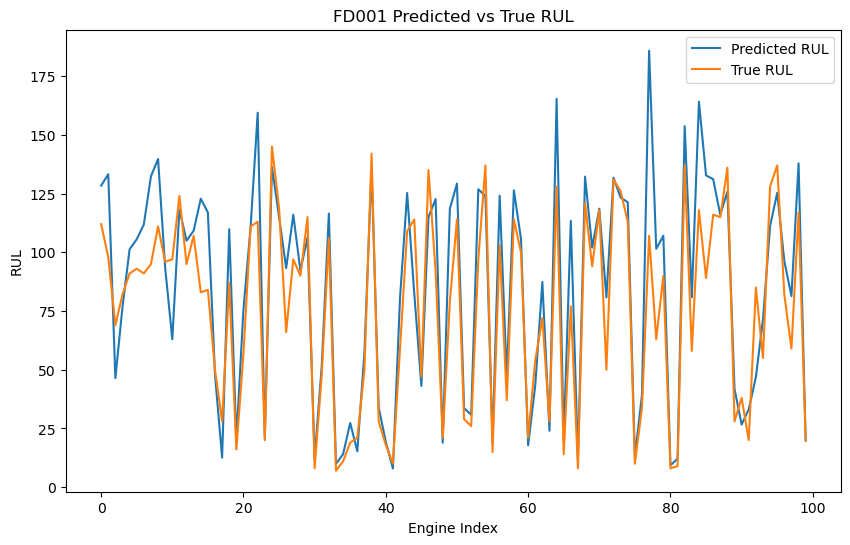

Root Mean Squared Error (RMSE): 20.4885198433097
Mean Absolute Error (MAE): 15.052255611419678


In [ ]:
FD001_true_rul = pd.read_csv(
    project_root / 'data/raw/CMAPSSData/RUL_FD001.txt', 
    sep=' ', 
    header=None
).dropna(axis=1, how='all').iloc[:, 0].values

# Process test data with masking
FD001_X_test, FD001_test_mask, FD001_num_test_windows_list = process_test_data_with_sliding_windows(
    test_FD001_processed, FD001_window_size
)

# Predict RUL using the model
FD001_model_output = FD001_model.predict(FD001_X_test)

# Apply masking to predictions
FD001_predicted_rul = []
start_idx = 0

# Ensure mask is a proper array
FD001_test_mask = np.array(FD001_test_mask)

# Process predictions engine by engine
for num_windows, mask in zip(FD001_num_test_windows_list, FD001_test_mask):
    engine_predictions = FD001_model_output[start_idx:start_idx + num_windows]
    mask = np.array(mask)  # Ensure mask is a NumPy array
    valid_predictions = engine_predictions[mask == 1]  # Use mask to filter valid rows
    FD001_predicted_rul.append(valid_predictions.mean())  # Average predictions for valid rows
    start_idx += num_windows

FD001_predicted_rul = np.array(FD001_predicted_rul)

FD001_predicted_rul = FD001_scaler.inverse_transform(FD001_predicted_rul.reshape(-1, 1)).flatten()

# Print predicted RUL for each engine
print('FD001')
for engine_id, predicted_rul_value in enumerate(FD001_predicted_rul, start=1):
    print(f"Engine {engine_id}: Predicted RUL = {predicted_rul_value}")

# Plot predicted vs true RUL
plt.figure(figsize=(10, 6))
plt.plot(range(len(FD001_predicted_rul)), FD001_predicted_rul, label='Predicted RUL')
plt.plot(range(len(FD001_true_rul)), FD001_true_rul, label='True RUL')
plt.legend()
plt.title('FD001 Predicted vs True RUL')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.show()

#### Plotting FD002

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
FD002
Engine 1: Predicted RUL = 11.52493667602539
Engine 2: Predicted RUL = 149.26351928710938
Engine 3: Predicted RUL = 110.40283966064453
Engine 4: Predicted RUL = 72.5224838256836
Engine 5: Predicted RUL = 9.75607967376709
Engine 6: Predicted RUL = 154.01406860351562
Engine 7: Predicted RUL = 26.512020111083984
Engine 8: Predicted RUL = 51.2979850769043
Engine 9: Predicted RUL = 14.507745742797852
Engine 10: Predicted RUL = 107.77247619628906
Engine 11: Predicted RUL = 29.749853134155273
Engine 12: Predicted RUL = 117.14068603515625
Engine 13: Predicted RUL = 65.89044952392578
Engine 14: Predicted RUL = 18.128076553344727
Engine 15: Predicted RUL = 50.66496658325195
Engine 16: Predicted RUL = 139.5332489013672
Engine 17: Predicted RUL = 65.02984619140625
Engine 18: Predicted RUL = 153.05148315429688
Engine 19: Predicted RUL = 18.347976684570312
Engine 20: Predicted RUL = 95.58540344238281
Engine 21: Predicted RUL = 58.96256637573242
Engine 22: P

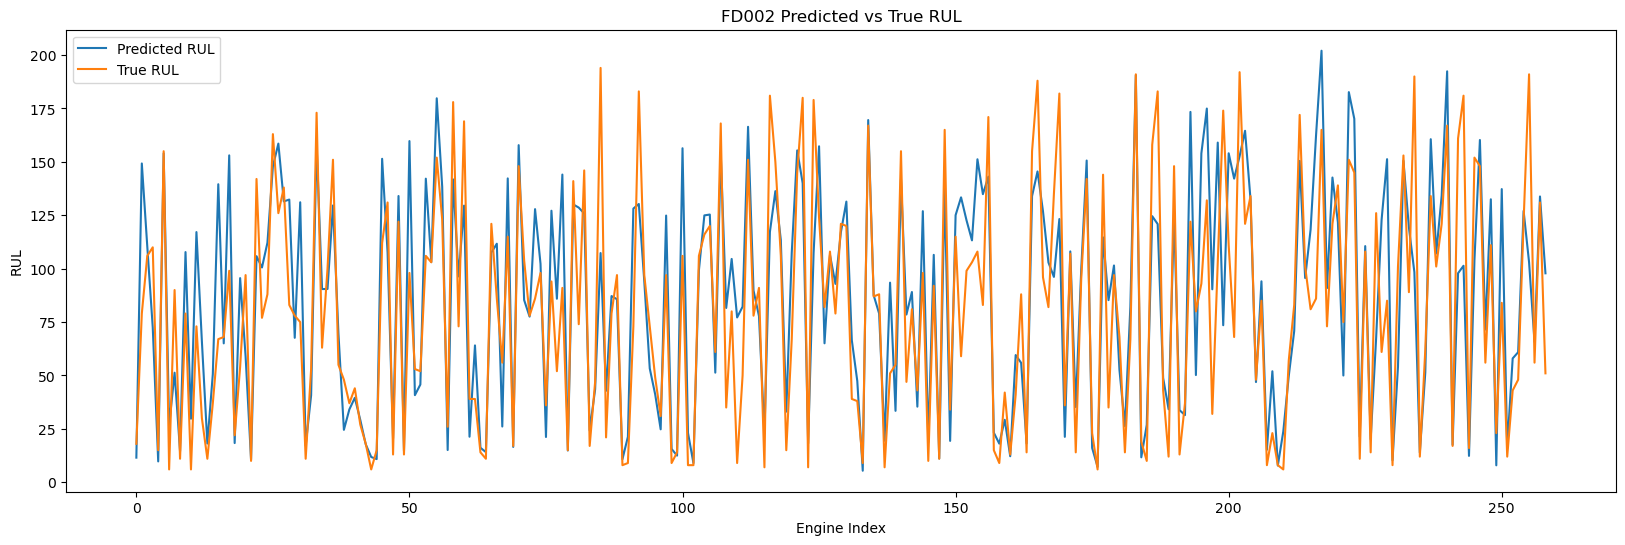

Root Mean Squared Error (RMSE): 31.00836889763734
Mean Absolute Error (MAE): 22.972944819328866


In [ ]:
FD002_true_rul = pd.read_csv(
    project_root / 'data/raw/CMAPSSData/RUL_FD002.txt', 
    sep=' ', 
    header=None
).dropna(axis=1, how='all').iloc[:, 0].values

# Process test data with masking
FD002_X_test, FD002_test_mask, FD002_num_test_windows_list = process_test_data_with_sliding_windows(
    test_FD002_processed, FD002_window_size
)

# Predict RUL using the model
FD002_model_output = FD002_model.predict(FD002_X_test)

# Apply masking to predictions
FD002_predicted_rul = []
start_idx = 0

# Ensure mask is a proper array
FD002_test_mask = np.array(FD002_test_mask)

# Process predictions engine by engine
for num_windows, mask in zip(FD002_num_test_windows_list, FD002_test_mask):
    engine_predictions = FD002_model_output[start_idx:start_idx + num_windows]
    mask = np.array(mask)  # Ensure mask is a NumPy array
    valid_predictions = engine_predictions[mask == 1]  # Use mask to filter valid rows
    FD002_predicted_rul.append(valid_predictions.mean())  # Average predictions for valid rows
    start_idx += num_windows

FD002_predicted_rul = np.array(FD002_predicted_rul)

FD002_predicted_rul = FD002_scaler.inverse_transform(FD002_predicted_rul.reshape(-1, 1)).flatten()

FD002_predicted_rul = np.nan_to_num(FD002_predicted_rul, nan=0.0)


# Print predicted RUL for each engine
print('FD002')
for engine_id, predicted_rul_value in enumerate(FD002_predicted_rul, start=1):
    print(f"Engine {engine_id}: Predicted RUL = {predicted_rul_value}")

# Plot predicted vs true RUL
plt.figure(figsize=(20, 6))
plt.plot(range(len(FD002_predicted_rul)), FD002_predicted_rul, label='Predicted RUL')
plt.plot(range(len(FD002_true_rul)), FD002_true_rul, label='True RUL')
plt.legend()
plt.title('FD002 Predicted vs True RUL')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.show()

#### Plotting FD003

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
FD003
Engine 1: Predicted RUL = 42.370304107666016
Engine 2: Predicted RUL = 53.43153762817383
Engine 3: Predicted RUL = 38.67713928222656
Engine 4: Predicted RUL = 144.52304077148438
Engine 5: Predicted RUL = 202.64907836914062
Engine 6: Predicted RUL = 136.655029296875
Engine 7: Predicted RUL = 54.98235321044922
Engine 8: Predicted RUL = 80.66065216064453
Engine 9: Predicted RUL = 74.4381332397461
Engine 10: Predicted RUL = 66.1859130859375
Engine 11: Predicted RUL = 63.23085403442383
Engine 12: Predicted RUL = 149.64132690429688
Engine 13: Predicted RUL = 112.68053436279297
Engine 14: Predicted RUL = 33.579551696777344
Engine 15: Predicted RUL = 173.47129821777344
Engine 16: Predicted RUL = 59.78917694091797
Engine 17: Predicted RUL = 104.72882843017578
Engine 18: Predicted RUL = 146.80714416503906
Engine 19: Predicted RUL = 123.2745590209961
Engine 20: Predicted RUL = 68.60888671875
Engine 21: Predicted RUL = 19.86811065673828
Engine 22: Predic

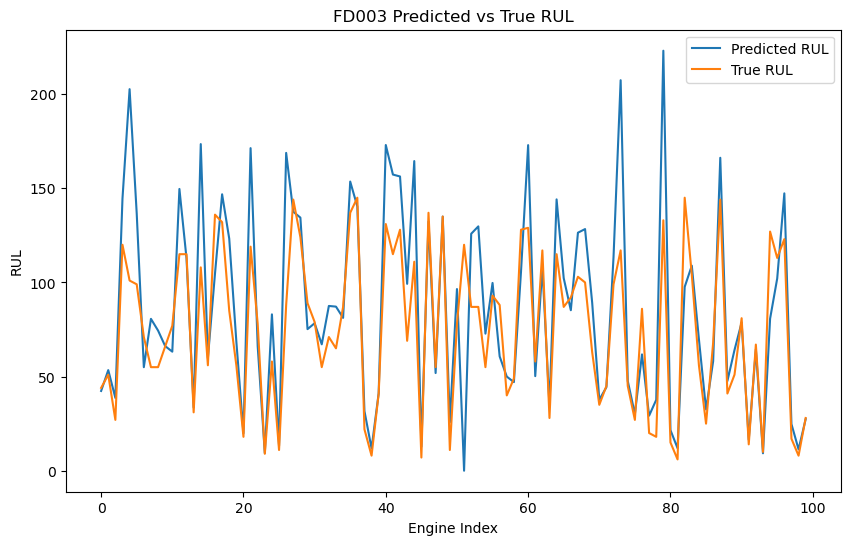

Root Mean Squared Error (RMSE): 30.23601797980762
Mean Absolute Error (MAE): 19.80769260406494


In [ ]:
FD003_true_rul = pd.read_csv(
    project_root / 'data/raw/CMAPSSData/RUL_FD003.txt', 
    sep=' ', 
    header=None
).dropna(axis=1, how='all').iloc[:, 0].values

# Process test data with masking
FD003_X_test, FD003_test_mask, FD003_num_test_windows_list = process_test_data_with_sliding_windows(
    test_FD003_processed, FD003_window_size
)

# Predict RUL using the model
FD003_model_output = FD003_model.predict(FD003_X_test)

# Apply masking to predictions
FD003_predicted_rul = []
start_idx = 0

# Ensure mask is a proper array
FD003_test_mask = np.array(FD003_test_mask)

# Process predictions engine by engine
for num_windows, mask in zip(FD003_num_test_windows_list, FD003_test_mask):
    engine_predictions = FD003_model_output[start_idx:start_idx + num_windows]
    mask = np.array(mask)  # Ensure mask is a NumPy array
    valid_predictions = engine_predictions[mask == 1]  # Use mask to filter valid rows
    FD003_predicted_rul.append(valid_predictions.mean())  # Average predictions for valid rows
    start_idx += num_windows

FD003_predicted_rul = np.array(FD003_predicted_rul)

FD003_predicted_rul = FD003_scaler.inverse_transform(FD003_predicted_rul.reshape(-1, 1)).flatten()

FD003_predicted_rul = np.nan_to_num(FD003_predicted_rul, nan=0.0)

# Print predicted RUL for each engine
print('FD003')
for engine_id, predicted_rul_value in enumerate(FD003_predicted_rul, start=1):
    print(f"Engine {engine_id}: Predicted RUL = {predicted_rul_value}")

# Plot predicted vs true RUL
plt.figure(figsize=(10, 6))
plt.plot(range(len(FD003_predicted_rul)), FD003_predicted_rul, label='Predicted RUL')
plt.plot(range(len(FD003_true_rul)), FD003_true_rul, label='True RUL')
plt.legend()
plt.title('FD003 Predicted vs True RUL')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.show()

#### Plotting FD004

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
FD004
Engine 1: Predicted RUL = 48.9078483581543
Engine 2: Predicted RUL = 76.97310638427734
Engine 3: Predicted RUL = 149.43421936035156
Engine 4: Predicted RUL = 213.8282012939453
Engine 5: Predicted RUL = 100.90298461914062
Engine 6: Predicted RUL = 180.3362274169922
Engine 7: Predicted RUL = 113.56404876708984
Engine 8: Predicted RUL = 19.859086990356445
Engine 9: Predicted RUL = 139.64205932617188
Engine 10: Predicted RUL = 132.0538330078125
Engine 11: Predicted RUL = 170.58905029296875
Engine 12: Predicted RUL = 16.443246841430664
Engine 13: Predicted RUL = 72.4362564086914
Engine 14: Predicted RUL = 120.1191635131836
Engine 15: Predicted RUL = 21.015052795410156
Engine 16: Predicted RUL = 198.2691192626953
Engine 17: Predicted RUL = 131.4635009765625
Engine 18: Predicted RUL = 112.79010009765625
Engine 19: Predicted RUL = 196.2859649658203
Engine 20: Predicted RUL = 121.42678833007812
Engine 21: Predicted RUL = 118.25401306152344
Engine 22: 

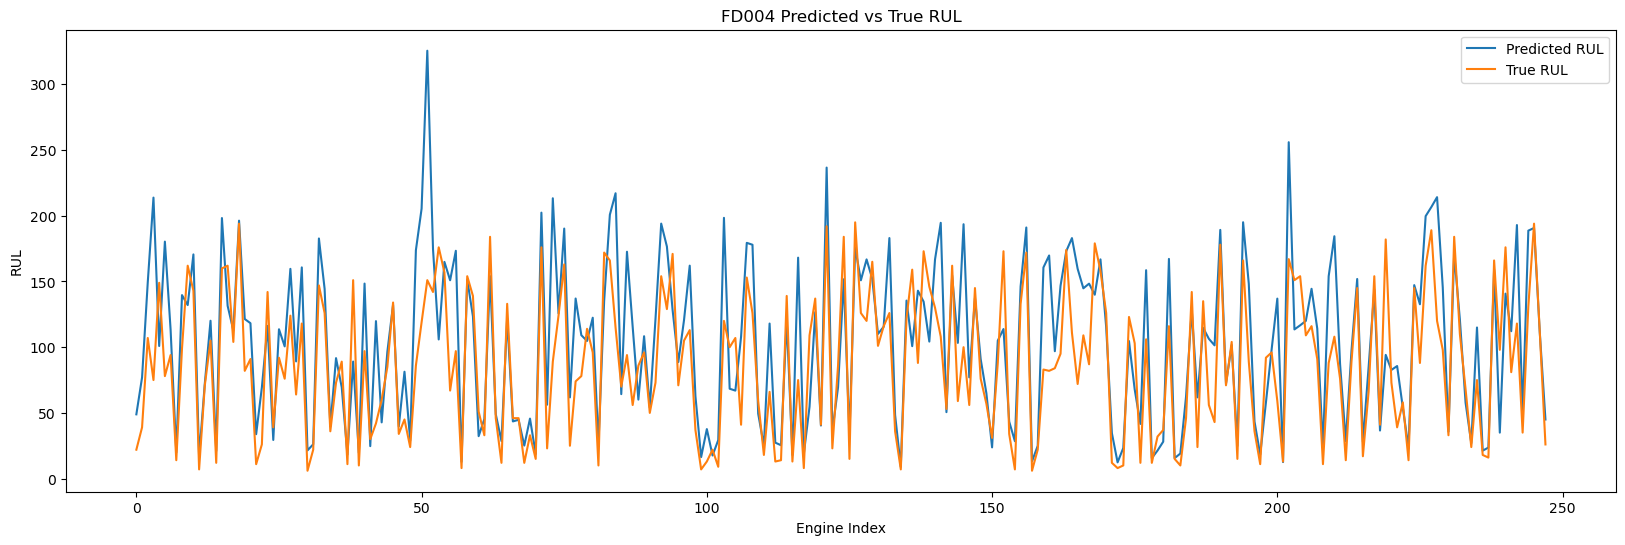

Root Mean Squared Error (RMSE): 40.56794427550128
Mean Absolute Error (MAE): 29.489132173599735


In [ ]:
FD004_true_rul = pd.read_csv(
    project_root / 'data/raw/CMAPSSData/RUL_FD004.txt', 
    sep=' ', 
    header=None
).dropna(axis=1, how='all').iloc[:, 0].values

# Process test data with masking
FD004_X_test, FD004_test_mask, FD004_num_test_windows_list = process_test_data_with_sliding_windows(
    test_FD004_processed, FD004_window_size
)

# Predict RUL using the model
FD004_model_output = FD004_model.predict(FD004_X_test)

# Apply masking to predictions
FD004_predicted_rul = []
start_idx = 0

# Ensure mask is a proper array
FD004_test_mask = np.array(FD004_test_mask)

# Process predictions engine by engine
for num_windows, mask in zip(FD004_num_test_windows_list, FD004_test_mask):
    engine_predictions = FD004_model_output[start_idx:start_idx + num_windows]
    mask = np.array(mask)  # Ensure mask is a NumPy array
    valid_predictions = engine_predictions[mask == 1]  # Use mask to filter valid rows
    FD004_predicted_rul.append(valid_predictions.mean())  # Average predictions for valid rows
    start_idx += num_windows

FD004_predicted_rul = np.array(FD004_predicted_rul)

FD004_predicted_rul = FD004_scaler.inverse_transform(FD004_predicted_rul.reshape(-1, 1)).flatten()

FD004_predicted_rul = np.nan_to_num(FD004_predicted_rul, nan=0.0)

# Print predicted RUL for each engine
print('FD004')
for engine_id, predicted_rul_value in enumerate(FD004_predicted_rul, start=1):
    print(f"Engine {engine_id}: Predicted RUL = {predicted_rul_value}")

# Plot predicted vs true RUL
plt.figure(figsize=(20, 6))
plt.plot(range(len(FD004_predicted_rul)), FD004_predicted_rul, label='Predicted RUL')
plt.plot(range(len(FD004_true_rul)), FD004_true_rul, label='True RUL')
plt.legend()
plt.title('FD004 Predicted vs True RUL')
plt.xlabel('Engine Index')
plt.ylabel('RUL')
plt.show()

## Combined Plotting of True RULs vs Predicted RULs

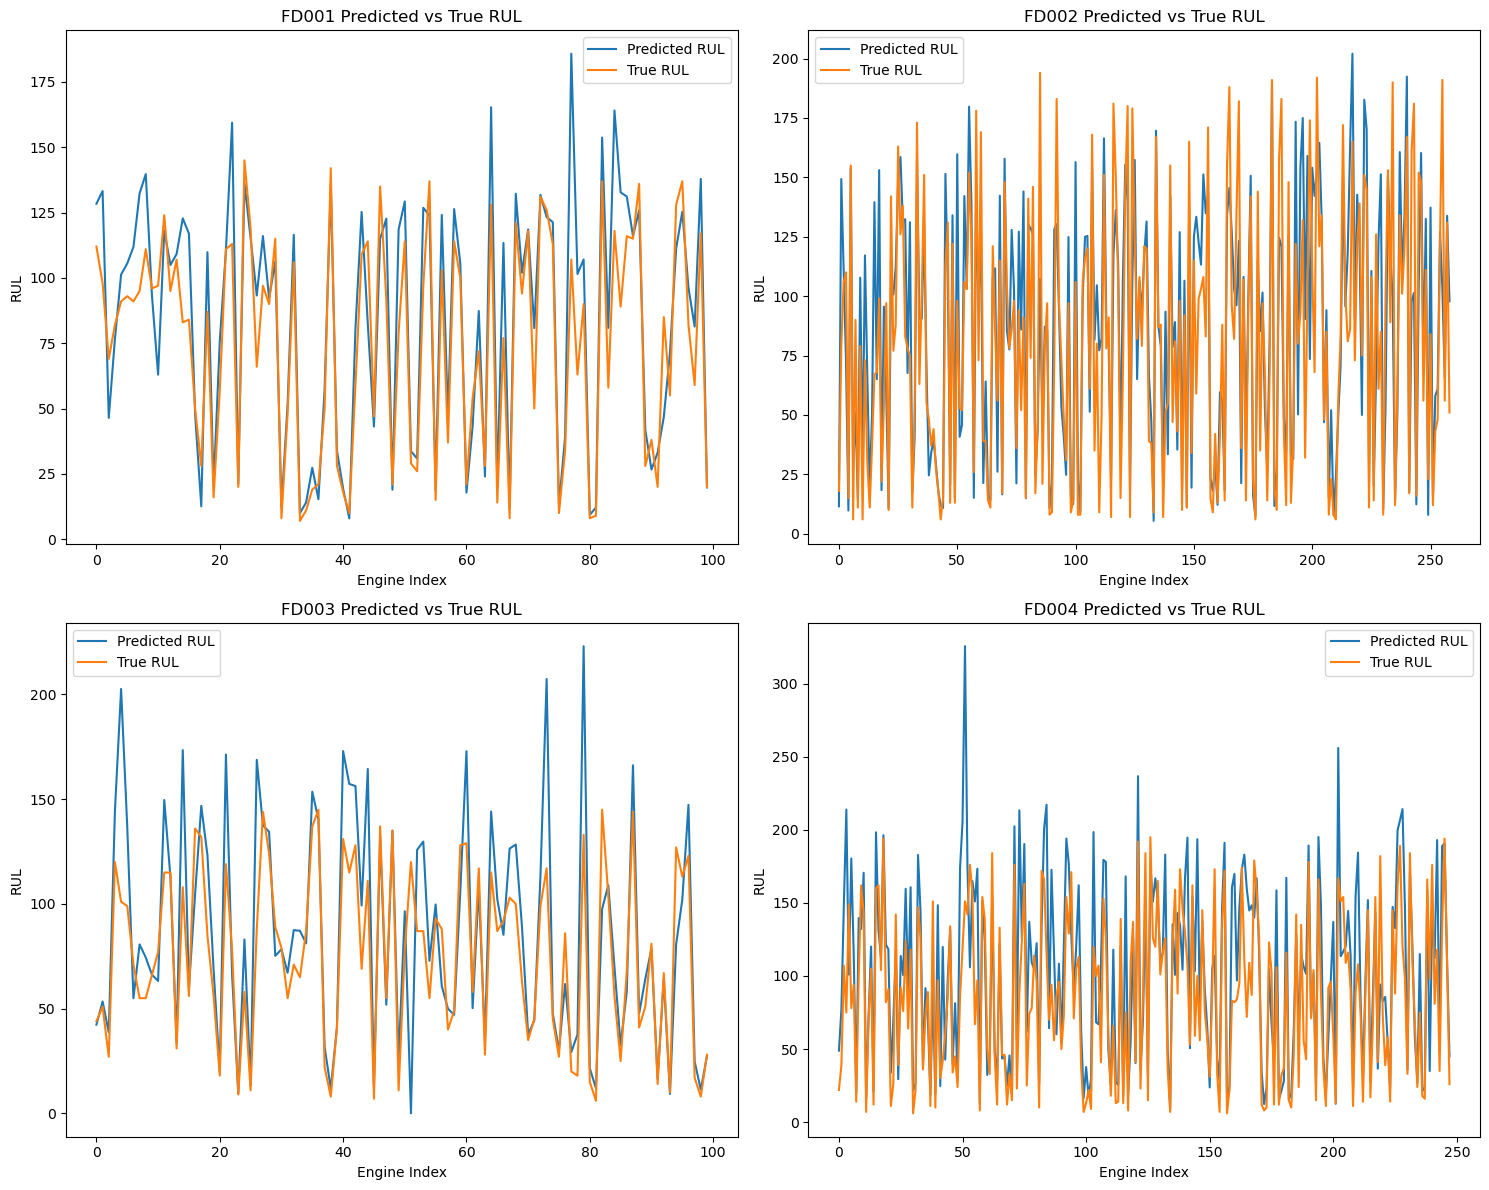

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Data for each dataset
datasets = [
    ('FD001', FD001_predicted_rul, FD001_true_rul),
    ('FD002', FD002_predicted_rul, FD002_true_rul),
    ('FD003', FD003_predicted_rul, FD003_true_rul),
    ('FD004', FD004_predicted_rul, FD004_true_rul),
]

# Loop through datasets and plot each
for i, (title, predicted, true) in enumerate(datasets):
    axes[i].plot(range(len(predicted)), predicted, label='Predicted RUL')
    axes[i].plot(range(len(true)), true, label='True RUL')
    axes[i].legend()
    axes[i].set_title(f'{title} Predicted vs True RUL')
    axes[i].set_xlabel('Engine Index')
    axes[i].set_ylabel('RUL')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

## Printing Performance Metrics

The performance metrics we decided to use:

1. Root Mean Squared Error (RMSE): We decided to use RMSE as it penalizes large errors more than small errors, making it sensitive to significant deviations in predictions.
2. Mean Absolute Error (MAE): We decided to use MAE due to its robustness to outliers and easily interpretable error measure.
3. Custom Asymmetric Penalty Score: We decided to create a custom score to penalize over-predictions rather than under-predictions. This is because in the real world, an over-prediction of the RUL of a jet engine is much more detrimental compared to an under-prediction.

In [50]:
def asymmetric_penalty_score(y_true, y_pred, over_penalty=2.0, under_penalty=1.0):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = y_pred - y_true  # Positive error indicates over-prediction

    # Separate over-predictions and under-predictions
    over_error = error[error > 0]
    under_error = error[error <= 0]

    # Compute penalties
    over_penalty_score = np.sum(over_penalty * (over_error ** 2))  # Higher penalty for over-prediction
    under_penalty_score = np.sum(under_penalty * (under_error ** 2))  # Lower penalty for under-prediction

    total_score = over_penalty_score + under_penalty_score
    return total_score / len(y_true)  # Normalize by the number of samples

In [ ]:
print('FD001')
FD001_rmse = np.sqrt(mean_squared_error(FD001_true_rul, FD001_predicted_rul))
FD001_mae = mean_absolute_error(FD001_true_rul, FD001_predicted_rul)
FD001_custom = asymmetric_penalty_score(FD001_true_rul, FD001_predicted_rul)
print(f"Root Mean Squared Error (RMSE): {FD001_rmse}")
print(f"Mean Absolute Error (MAE): {FD001_mae}")
print(f"Custom Penalty Score: {FD001_custom}")

print('FD002')
FD002_rmse = np.sqrt(mean_squared_error(FD002_true_rul, FD002_predicted_rul))
FD002_mae = mean_absolute_error(FD002_true_rul, FD002_predicted_rul)
FD002_custom = asymmetric_penalty_score(FD002_true_rul, FD002_predicted_rul)
print(f"Root Mean Squared Error (RMSE): {FD002_rmse}")
print(f"Mean Absolute Error (MAE): {FD002_mae}")
print(f"Custom Penalty Score: {FD002_custom}")

print('FD003')
FD003_rmse = np.sqrt(mean_squared_error(FD003_true_rul, FD003_predicted_rul))
FD003_mae = mean_absolute_error(FD003_true_rul, FD003_predicted_rul)
FD003_custom = asymmetric_penalty_score(FD003_true_rul, FD003_predicted_rul)
print(f"Root Mean Squared Error (RMSE): {FD003_rmse}")
print(f"Mean Absolute Error (MAE): {FD003_mae}")
print(f"Custome Penalty Score: {FD003_custom}")

print('FD004')
FD004_rmse = np.sqrt(mean_squared_error(FD004_true_rul, FD004_predicted_rul))
FD004_mae = mean_absolute_error(FD004_true_rul, FD004_predicted_rul)
FD004_custom = asymmetric_penalty_score(FD004_true_rul, FD004_predicted_rul)
print(f"Root Mean Squared Error (RMSE): {FD004_rmse}")
print(f"Mean Absolute Error (MAE): {FD004_mae}")
print(f"Custom Penalty Score: {FD004_custom}")

FD001
Root Mean Squared Error (RMSE): 20.4885198433097
Mean Absolute Error (MAE): 15.052255611419678
Mean Absolute Percentage Error (MAPE): 778.9236793356729
FD002
Root Mean Squared Error (RMSE): 31.00836889763734
Mean Absolute Error (MAE): 22.972944819328866
Mean Absolute Percentage Error (MAPE): 1524.2532974296728
FD003
Root Mean Squared Error (RMSE): 30.23601797980762
Mean Absolute Error (MAE): 19.80769260406494
Mean Absolute Percentage Error (MAPE): 1599.2610045785864
FD004
Root Mean Squared Error (RMSE): 40.56794427550128
Mean Absolute Error (MAE): 29.489132173599735
Mean Absolute Percentage Error (MAPE): 3051.357038365096


It seems that our model performs less efficiently the more complex the dataset is. The more conditions and fault modes the turbo jet engines are under, the higher our errors are.

## Parameter Tuning

In attempt to find better hyperparameters compared to our initial values during testing, we implemented an automated hyperparameter optimization framework, Optuna, which uses a history of trials to estimate which hyper parameters to try next.

This, although efficient, takes VERY long. So we utilize 5 cores and give it only a few choices for hyperparameters to run through.

We do this for each dataset and mark down the best values.

In [ ]:
datasets = {
    "FD001": {"train": train_FD001_processed, "scaler": FD001_scaler},
    "FD002": {"train": train_FD002_processed, "scaler": FD002_scaler},
    "FD003": {"train": train_FD003_processed, "scaler": FD003_scaler},
    "FD004": {"train": train_FD004_processed, "scaler": FD004_scaler}
}

best_results = {dataset_name: {"best_rmse": float('inf'), "best_params": None} for dataset_name in datasets.keys()}

def objective(trial, dataset_name, data_info):
    # Load dataset-specific data
    train_data = data_info["train"]
    scaler = data_info["scaler"]

    # Hyperparameters to tune
    window_size = trial.suggest_categorical("window_size", [5, 10, 20, 30, 40])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.001, 0.0001])
    epochs = trial.suggest_categorical("epochs", [10, 20, 30])

    # Split train data into training and validation sets
    train_split, val_split = train_test_split(train_data, test_size=0.2, random_state=42)
    
    # Generate sliding windows for training and validation data
    X_train, y_train, train_mask = process_data_with_sliding_windows(train_split, window_size)
    X_val, y_val, val_mask = process_data_with_sliding_windows(val_split, window_size)

    # Build and compile model
    input_shape = (window_size, X_train.shape[2])
    model = build_lstm_model(input_shape, learning_rate)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        )
    ]

    # Train model
    history = model.fit(
        X_train,
        y_train,
        sample_weight=train_mask,
        validation_data=(X_val, y_val, val_mask),
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        callbacks=callbacks
    )

    # Predict RUL on the validation set
    model_output = model.predict(X_val, verbose=0)

    # Apply masking and calculate mean predictions
    predicted_rul = []
    for mask, engine_predictions in zip(val_mask, model_output):
        valid_predictions = engine_predictions[mask == 1]
        predicted_rul.append(valid_predictions.mean() if len(valid_predictions) > 0 else 0.0)

    predicted_rul = np.array(predicted_rul)

    # Inverse scale predictions
    predicted_rul = scaler.inverse_transform(predicted_rul.reshape(-1, 1)).flatten()
    predicted_rul = np.nan_to_num(predicted_rul, nan=0.0)  # Handle NaN values

    # Load true RUL from the validation set
    true_rul = y_val

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(true_rul, predicted_rul))
    return rmse

# Run Optuna for each dataset
for dataset_name, data_info in datasets.items():
    print(f"Running Optuna hyperparameter tuning for {dataset_name}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, dataset_name, data_info), n_trials=30, n_jobs=1)

    # Save the best result for the dataset
    best_results[dataset_name] = {"best_rmse": study.best_value, "best_params": study.best_params}
    print(f"Best RMSE for {dataset_name}: {study.best_value}")
    print(f"Best Hyperparameters for {dataset_name}: {study.best_params}")

# Display results
for dataset, result in best_results.items():
    print(f"{dataset}: Best RMSE = {result['best_rmse']}, Best Params = {result['best_params']}")

# Next Steps

Our model currently performs well for jet engines that fail under relatively non-complex conditions.

We could improve our model in the future by implementing the custom asymmetric penalty score in the Optuna Parameter tuning to favor a model that leads to more under-predictions rather than over-predictions.

We can also have more data to train our model as we are creating 4 different models using 1000 pieces of data.